# Processing sequences with RNN and CNN

In this chapter we will discuss about __RNNs(Recurrent Neural Networks)__ which can predict the future(sort of) such as the next word in a sentence, or the
temperature of tomorrow ...etc. Once an RNN learns past patterns in the data, it is able to use its knowledge to forecast the future, assuming of course 
that past patterns still hold in the future. We are going to talk about the functionning of RNNS and use it to forecast a time series.

## Recurrent neurons and layers

A recurrent neural network is much like the regular feed forward network we used before, the difference being that is possess backward connections. At each 
time step _t_ (also called a frame), this recurrent neuron receives the inputs x as well as its own output from the previous time step $\hat{y}_{(t-1)}$.
Each recurrent network as 2 sets of weights, 1 for the inputs(called $w_x$) and 1 for the outputs(called $w_{\hat{y}}$) from the previous time step. And we
take into account the layer entirely we can defined the matrices of weights as $\textbf{W}_x$ and $\textbf{W}_{\hat{y}}$. The output of a recurrent layer 
for a single instance can be computed using the following equation:
$$\hat{y}_{(t)} = \emptyset(W_{x}^{T}x_{(t)} + W_{\hat{y}}^{T} \hat{y}_{(t-1)} + \textbf{b})$$
- __b__: is the vector containing each neurons bias term
- $\emptyset$: is the activation function(ReLU).

### Memory cells

A memory cell is a neuron that conserve some state accross the time steps. A cell state over some time step _t_ denoted __h__(t) is defined by the following
function:
$$\text{h}_{(t)} = f(\textbf{x}_{(t)}, h_{(t-1)})$$
A RNN can take a sequence of inputs and outputs another sequence(this is called a __sequence-to-sequence network__) and is very common for time series
forecasting, another type of RNNs is to feed him a sequence of inputs and ignore the sequence of outputs except the last one(this is called a
__sequence to vector network__), we could also feed the network the same vector of inputs on repeat and get a sequence of outputs(called a
__vector to sequence network__) for example feeding a RNN an image and ask it for a caption and lastly we could have a __sequence to vector network__ or
__encoder__ used for automatic language translation for example.

## Training Recurrent Neural Networks

To train RNNS we can use a strategy called __backpropragation through time__(BPTT). Similarly to regular backpropagation we perform a first forward pass,
then the output is evaluated using a loss function, the gradients of the loss function is propagated backward through the network. Once the backward phase 
is complete and all the gradients have been computed, BPTT can perform a gradient descent step to update the parameters (this is no different from regular 
backprop). We are going to load a time series with keras uses it as an example. We are going to try to predict the number of passengers that will ride the
bus or the train provided the data of past years.

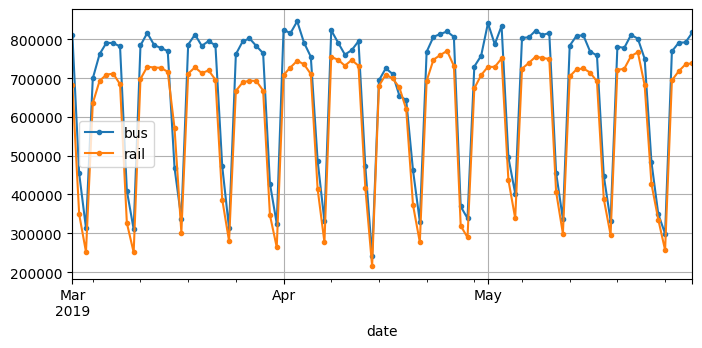

In [5]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

path = Path("datasets/CTA_-_Ridership_-_Daily_Boarding_Totals_20240901.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1) # the total is just bus + rail so it is useless to keep it
df = df.drop_duplicates()

# Let's visualize it
# print(df.head())
df["2019-03": "2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

This type of plots is produced by a _time series_(data with values at different time steps usually at regular interval), here it is a 
__multivariate time series__ where there are multiple values per time step. As we can observe the same patterns repeat themselves every weeks this is called
_weekly seasonality_. One way of forecasting this type of data is __naive forecasting__ which means copying the values from the past for our predictions.
Let's visualize this type of forecasting by lagging(shifting the values toward the right) using dotted lines. Let's also plot the difference between the 2
(called _differencing_).

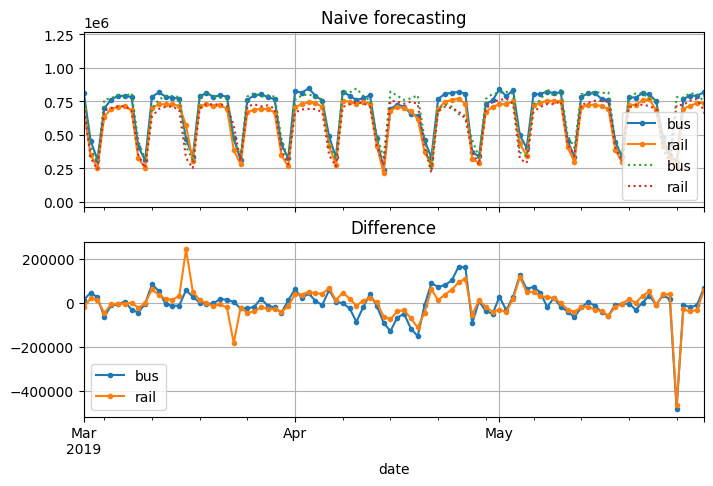

In [8]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=True, marker=".") # The predictions are represented by dotted lines
df.shift(7).plot(title="Naive forecasting", ax=axs[0], grid=True, legend=True, linestyle=":")
diff_7.plot(title="Difference", ax=axs[1], grid=True, marker=".")
plt.show()

When a time series is correlated with a lagged version of itself we say that it is _autocorrelated_. We can look at the Mean Absolute Error of the
predictions.

In [9]:
print(diff_7.abs().mean())

bus     43915.608696
rail    42143.271739
dtype: float64


Computing the percentage of errors make the most sense actually.

In [10]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
print((diff_7 / targets).abs().mean()) # This is called the mean absolute percentage error(MAPE)

bus     0.082938
rail    0.089948
dtype: float64


## The ARMA(autoregressive moving average) model family 

This is a very popular family of statistical model used to analyze time series. Its computs its forecasts by a weighted sum of lagged values and correct
these forecasts by adding a moving average, the moving average being computed using the weighted sum of the last few forecast errors. Here is equation it
uses:
$$\hat{y}_{(t)} = \sum_{i=1}^{p}\alpha _i y_{(t-1)} + \sum_{i=1}^{q}\emptyset _i \epsilon _{(t-i)} $$
where
$$\epsilon _(t)= y_{(t)} - \hat{y}_{(t)}$$
- $\hat{y}_{(t)}$ is the model's forecast for the time step t.
- $y_{(t)}$ is the time series value at time step t.
- The first sum is the weighted sum of the past p values of the time series, using the learned weights $\alpha _i$ . The number p is a hyperparameter, and 
 it determines how far back into the past the model should look. This sum is the autoregressive component of the model: it performs regression based on 
 past values.
- The second sum is the weighted sum over the past q forecast errors $\epsilon$ , using the learned weights θ . The number q is a hyperparameter. This sum 
 is the moving average component of the model.  
If the original time series has a quadratic trend instead of a linear trend, then a single round of differencing will not be enough. For example, the series
[1, 4, 9, 16, 25, 36] becomes [3, 5, 7, 9, 11] after one round of differencing, but if you run differencing for a second round, then you get [2, 2, 2, 2]. 
So, running two rounds of differencing will eliminate quadratic trends. More generally, running d consecutive rounds of differencing computes an 
approximation of the d order derivative of the time series, so it will eliminate polynomial trends up to degree d. This hyperparameter d is called the
__order of integration__.  
Differencing is the key component of the ARIMA (Autoregressive Integrated Moving Average) model. It runs on _d_ rounds of differencing to make time series
more stationary(a time series without any trend or seasonality), then apply a regular ARMA.   
We also have the __Seasonal ARIMA__ model which does the same thing as ARMA except it additionally model a _seasonal component_ for a given frequency
(weekly for example). The additional hyperparameters (added to the p, q ,d inherited from the default ARIMA) are _P_, _D_, _Q_, and _s_(the period of the
seasonal pattern), The hyperparameters P, D and Q are just like p, d, and q, but they are used to model the time series at t – s, t – 2s, t – 3s, etc. We
are going to try SARIMA to predict tomorrow ridership of the train dataset.

In [15]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D") # "daily" frequency
model = ARIMA(rail_series, order=(1, 0, 0), seasonal_order=(0, 1, 1, 7))# The hyperparameters p, d and q are set in the order argument
model = model.fit()
y_pred = model.forecast()

To get the best set of hyperparameters is to use grid search. Now we are going to use _tensorflow_ to forecast train rideship: we will try to predict
tomorrow's ridership by feeding it the numbers from the past 56 days(the inputs will be sequences). First we need to split the dataset:

In [20]:
import tensorflow as tf

rail_train = df["rail"]["2016-01":"2018-12"] / 1e6 # these divisions are just to scale the data
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

# Now we are going to use keras's timeseries_dataset_from_array function to transform our array into tensors which our model require
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets= rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets= rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

# Now let's try forecasting using a simple LinearModel
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, callbacks=[early_stopping_cb])

# Now let's try a RNN
model_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

# But this model is very innacurate so let's add the number of neurons and layers
model_rnn2 = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

# We can also try a deep RNN(which is just a stack layers of cells)
deep_rnn_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

e:\Notes\handsonml\mlnotes\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 249388919035868315910144.0000 - mae: 249388919035868315910144.0000 - val_loss: 597443527370500894359552.0000 - val_mae: 597443527370500894359552.0000
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 627863901701507836280832.0000 - mae: 627863901701507836280832.0000 - val_loss: 25329575118021557485568.0000 - val_mae: 25329575118021557485568.0000
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 195487064478127759556608.0000 - mae: 195487064478127759556608.0000 - val_loss: 117987671931256251088896.0000 - val_mae: 117987671931256251088896.0000
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 409817045681985598521344.0000 - mae: 409817045681985598521344.0000 - val_loss: 146174711207050164043776.0000 - val_mae: 146174711207050164043776.0000
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 303706798112786849202176.0000 - mae: 303706798112786849202176.0000 - val_loss: 55858059709163416374476

We can also train multivariate time series using nearly the same code. Let's try to train one using the rail and bus ride data.

In [ ]:
df_multivar = df[["bus", "rail"]] / 1e6
df_multivar["next_day_type"] = df["day_type"].shift(-1)
df_multivar = pd.get_dummies(df_multivar)

# Splitting the dataset
multivar_train = df_multivar["2016-01":"2018-12"]
multivar_valid = df_multivar["2019-01":"2019-05"]
multivar_test = df_multivar["2019-06":]

seq_length = 56
multivar_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_train.to_numpy(),
    targets= multivar_train["rail"][seq_length:],# To make the RNN forecast both the train and the bus we just set the targets to ["bus", "rail"]. Note that you should also add a neuron in the dense layer
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
multivar_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_valid.to_numpy(),
    targets= multivar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

multivar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]), # This is the only difference: at each time step the model uses 5 inputs instead of one.
    tf.keras.layers.Dense(1)
])

We can easily train a model to forecast several time steps ahead. In order to do that we could use the univar_model RNN, make it do a forecast one time
step from now, add that to the inputs and repeat the process for the number of steps we want.

In [ ]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):# This method will try to predict the nextt 14 values
    y_pred_one = multivar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

The other way of doing this is to train a RNN to predict the values in one go.

In [ ]:
def split_inputs_and_targets(multivar_series, ahead=14, target_col=1):
    return multivar_series[:, :-ahead], multivar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    multivar_train.to_numpy(), 
    targets=None, 
    sequence_length=seq_length + 14, 
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14) # For 14 outputs
])

X = multivar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred = ahead_model.predict(X)

Lastly we can train a sequence to sequence model to forecast many steps ahead.

In [ ]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))


def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1, batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

seq2seq_train = to_seq2seq_dataset(multivar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(multivar_valid)

seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),# return_sequences is essential so that it returns a sequence of values(each of size 32)
    tf.keras.layers.Dense(14)
])

The problem with simple RNNs is that they are quite inneficient for long sequences. To train an RNN on long sequences, we must run it over many time steps,
making the unrolled RNN a very deep network. Just like any deep neural network it may suffer from the unstable gradients problem, it may take forever to
train, or training may be unstable. A solution that seems to work well is called _layer normalization_. It is similar to batch normalizatio, it normalize
across the feature dimension instead of across batch dimensions. It is usually used right after the linear combination of the inputs and the hidden states.
We are going to implement a custom memory cell that apply layer normalization at each step:

In [ ]:
class SimpleCellRNN(tf.keras.layers.layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units, activation=None)
        self.norm_layer = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.norm_layer(inputs))
        return norm_outputs, [norm_outputs]

# And we use it this way:
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(SimpleCellRNN(32), return_sequences=True,
    input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

When traversing an RNN the data goes through a lot of transformations which leads to loss of informations each step. To solve that many long term memory
cells have been developped. One of them is __LSTM(Long Short Term Memory)__ we can use them exactly the same as Basic Cell.

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

A variant of the LSTM cell is the GRU(Gated Recurrent Unit), Keras provides a tf.keras.layers.GRU layer: using it is just a matter of replacing SimpleRNN 
or LSTM with GRU. It also provides a tf.keras.layers.GRUCell, in case you want to create a custom cell based on a GRU cell. Although these cells are
extremely efficient, they are still pretty sort memory we need to shorten the sequences using a 1D convolutional layer. If you use a 1D convolutional layer
with a stride of 1 and "same" padding, then the output sequence will have the same length as the input sequence but if you use "valid" padding or a stride 
greater than 1, then the output sequence will be shorter than the input sequence, so make sure you adjust the targets accordingly.

In [ ]:
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,  activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])